# **Part 1**

## **Step 1**
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

### **Data loading and initial data inspection**

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix,accuracy_score
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from scipy.stats import mode
import numpy as np


# Load the data
train_df = pd.read_csv('data/BBC News Train.csv')
test_df = pd.read_csv('data/BBC News Test.csv')

# Display the first few rows
print(train_df.head())

# Check for missing values
print(train_df.isnull().sum())

# Basic statistics: Number of articles per category
print(train_df['Category'].value_counts())
print(train_df.columns)


   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
ArticleId    0
Text         0
Category     0
dtype: int64
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
Index(['ArticleId', 'Text', 'Category'], dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2998542\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2998542\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Visualization

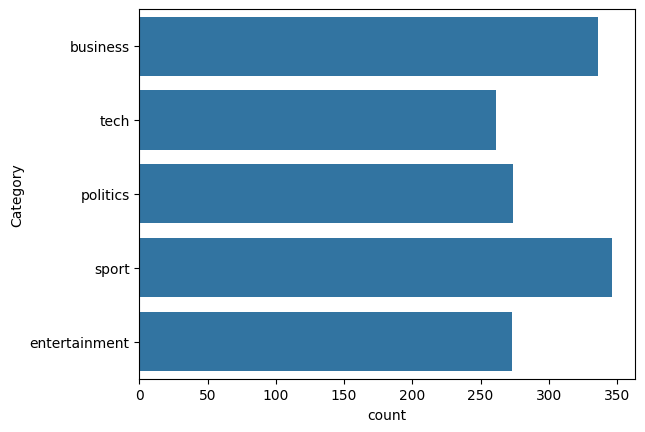

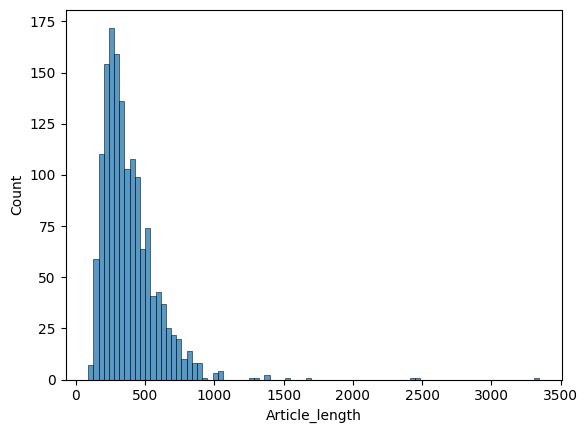

In [107]:
# Category Distribution
sns.countplot(y=train_df['Category'])
plt.show()

# Article Length Distribution
train_df['Article_length'] = train_df['Text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['Article_length'])
plt.show()


### Data Cleaning

In [108]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize, convert words to their root form. For instance, "running" becomes "run".
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

train_df['Cleaned_Article'] = train_df['Text'].apply(preprocess_text)
print(train_df['Cleaned_Article'].head())

# Preprocessing for test dataset
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)

from sklearn.model_selection import train_test_split

# Splitting the training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_df['Cleaned_Article'], 
    train_df['Category'], 
    test_size=0.2, 
    random_state=42
)


0    worldcom exboss launch defence lawyer defendin...
1    german business confidence slide german busine...
2    bbc poll indicates economic gloom citizen majo...
3    lifestyle governs mobile choice faster better ...
4    enron boss payout eighteen former enron direct...
Name: Cleaned_Article, dtype: object


### Word Embedding
For this problem we will use TF-IDF (Term Frequency-Inverse Document Frequency).

- TF (Term Frequency): It measures how frequently a term occurs in a document.

- IDF (Inverse Document Frequency): It measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, such as "is" or "and", may appear many times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones.


In [109]:
vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 words for simplicity
X_train = vectorizer.fit_transform(X_train_split)
X_val = vectorizer.transform(X_val_split)

### Word Statistic and visualizations

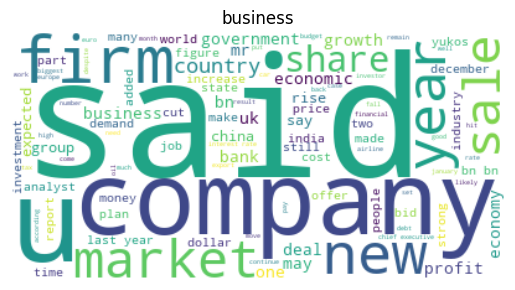

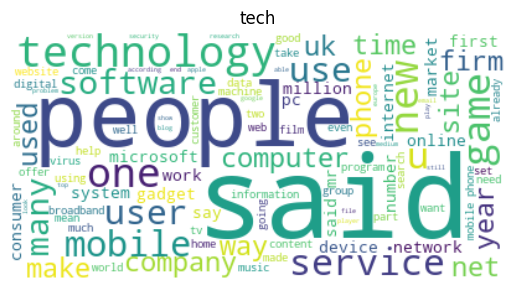

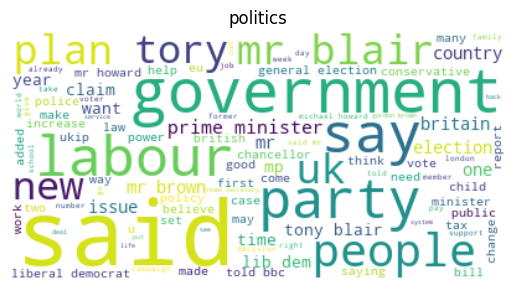

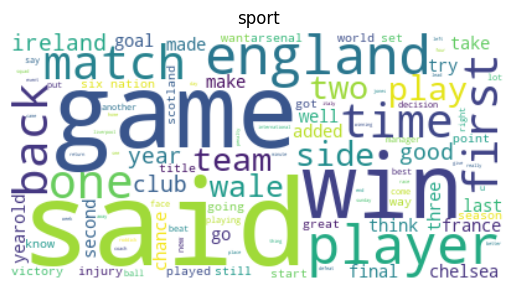

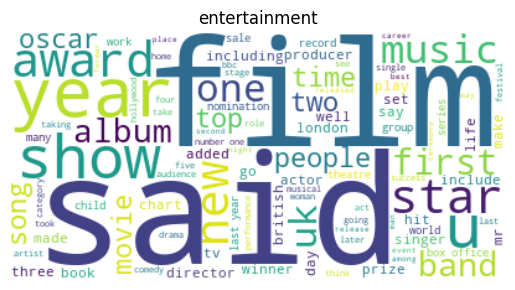

In [110]:
# Generate word cloud for each category
categories = train_df['Category'].unique()
for category in categories:
    subset = train_df[train_df['Category'] == category]
    text = ' '.join(subset['Cleaned_Article'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')
    plt.show()


## **Step 2:Building and training models. [35 pts]**

### Matrix Factorization Model

In [111]:
n_topics = 5  # There are 5 categories in the dataset; can be adjusted
nmf = NMF(n_components=n_topics, random_state=42)
W_train = nmf.fit_transform(X_train)
H = nmf.components_

### Predictions and performance metrics

Training Accuracy: 0.19546979865771813
Validation Accuracy: 0.20134228187919462


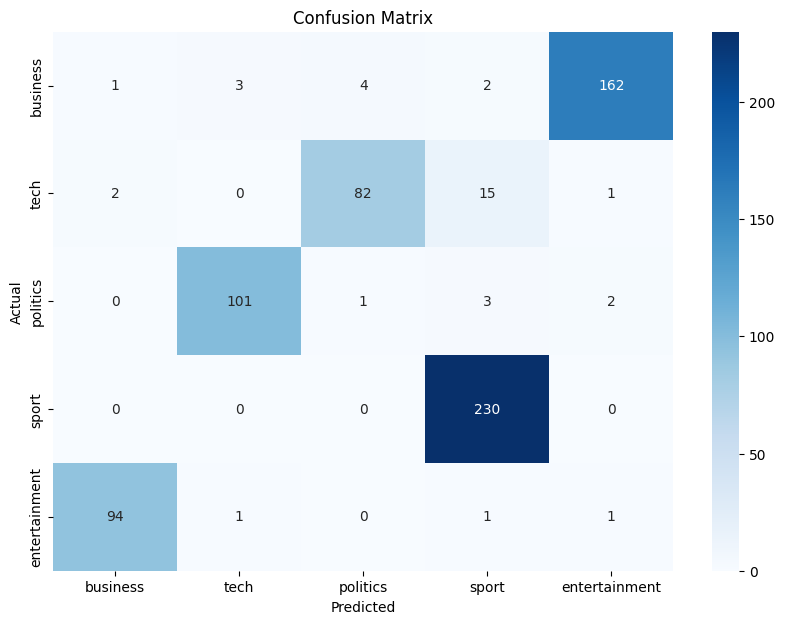

In [118]:
# Create label mapping
unique_categories = train_df['Category'].unique()
label_mapping = {category: index for index, category in enumerate(unique_categories)}

# Get dominant topic for each document
train_predictions = np.argmax(W_train, axis=1)

# For test data
X_test = vectorizer.transform(test_df['Cleaned_Text'])
W_test = nmf.transform(X_test)
test_predictions = np.argmax(W_test, axis=1)

train_accuracy = accuracy_score(y_train_split.map(label_mapping), train_predictions)
print("Training Accuracy:", train_accuracy)

# For validation data
W_val = nmf.transform(X_val)
val_predictions = np.argmax(W_val, axis=1)

val_accuracy = accuracy_score(y_val_split.map(label_mapping), val_predictions)
print("Validation Accuracy:", val_accuracy)

# For confusion matrix

# Get the numeric labels for the 'Category' column
true_labels = y_train_split.map(label_mapping)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, train_predictions, labels=list(label_mapping.values()))

# Adjust the confusion matrix to ensure all categories are reflected
if cm.shape[0] < len(unique_categories):
    missing_rows = len(unique_categories) - cm.shape[0]
    cm = np.vstack([cm, np.zeros((missing_rows, cm.shape[1]))])

if cm.shape[1] < len(unique_categories):
    missing_cols = len(unique_categories) - cm.shape[1]
    cm = np.hstack([cm, np.zeros((cm.shape[0], missing_cols))])

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Maximizing the training accuracy

In [ ]:
# Defining search space for hyperparameters
n_topics_range = [3, 5, 7, 10]  # The number of topics/components
max_features_range = [2000, 3000, 5000, 7000]  # Number of words to consider based on TF-IDF score

best_accuracy = 0
best_params = None

for n_topics in n_topics_range:
    for max_features in max_features_range:
        
        # Word embedding
        vectorizer = TfidfVectorizer(max_features=max_features)
        X_train = vectorizer.fit_transform(train_df['Cleaned_Article'])

        # Matrix Factorization using NMF
        nmf = NMF(n_components=n_topics, random_state=42)
        W_train = nmf.fit_transform(X_train)
        
        # Predictions
        train_predictions = np.argmax(W_train, axis=1)
        
        # Get the true labels corresponding to the current X_train
        current_true_labels = train_df['Category'].map(label_mapping)
        
        # Evaluation
        accuracy = accuracy_score(current_true_labels, train_predictions)
        
        print(f'n_topics: {n_topics}, max_features: {max_features}, Training Accuracy: {accuracy}')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_topics': n_topics, 'max_features': max_features}


print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_accuracy}")


n_topics: 3, max_features: 2000, Training Accuracy: 0.04563758389261745
n_topics: 3, max_features: 3000, Training Accuracy: 0.39865771812080536
n_topics: 3, max_features: 5000, Training Accuracy: 0.015436241610738255
n_topics: 3, max_features: 7000, Training Accuracy: 0.2040268456375839
n_topics: 5, max_features: 2000, Training Accuracy: 0.04899328859060403
n_topics: 5, max_features: 3000, Training Accuracy: 0.6382550335570469
n_topics: 5, max_features: 5000, Training Accuracy: 0.2395973154362416
n_topics: 5, max_features: 7000, Training Accuracy: 0.24295302013422818
n_topics: 7, max_features: 2000, Training Accuracy: 0.038926174496644296
n_topics: 7, max_features: 3000, Training Accuracy: 0.5919463087248322
n_topics: 7, max_features: 5000, Training Accuracy: 0.23557046979865773
n_topics: 7, max_features: 7000, Training Accuracy: 0.22617449664429531
n_topics: 10, max_features: 2000, Training Accuracy: 0.016778523489932886
n_topics: 10, max_features: 3000, Training Accuracy: 0.293288590

### Improving the model performance

 In esscence the new method :
- Uses NMF to extract latent topics from the text data.
- Assigns articles to these topics based on their content.
- Maps topics to the most frequent corresponding category.
- Validates the results against the known labels to determine the performance.

In [115]:
# Split the data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_df['Cleaned_Article'], 
    train_df['Category'], 
    test_size=0.2, 
    random_state=42
)

best_accuracy = 0
best_params = None

for n_topics in n_topics_range:
    for max_features in max_features_range:
        
        # Word embedding
        vectorizer = TfidfVectorizer(max_features=max_features)
        X_train = vectorizer.fit_transform(X_train_split)
        X_val = vectorizer.transform(X_val_split)
        
        # Matrix Factorization using NMF
        nmf = NMF(n_components=n_topics, random_state=42)
        W_train = nmf.fit_transform(X_train)
        W_val = nmf.transform(X_val)
        
        # Predictions
        train_predictions = np.argmax(W_train, axis=1)
        val_predictions = np.argmax(W_val, axis=1)
        
        # Map topics to labels
        topic_to_label_mapping = {}
        for i in range(n_topics):
            labels, counts = np.unique(y_train_split[train_predictions == i], return_counts=True)
            topic_to_label_mapping[i] = labels[np.argmax(counts)]
        mapped_train_predictions = [topic_to_label_mapping[t] for t in train_predictions]
        mapped_val_predictions = [topic_to_label_mapping[t] for t in val_predictions]
        
        # Evaluation
        train_accuracy = accuracy_score(y_train_split, mapped_train_predictions)
        val_accuracy = accuracy_score(y_val_split, mapped_val_predictions)
        
        print(f'n_topics: {n_topics}, max_features: {max_features}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'n_topics': n_topics, 'max_features': max_features}

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")


n_topics: 3, max_features: 2000, Training Accuracy: 0.6115771812080537, Validation Accuracy: 0.5973154362416108
n_topics: 3, max_features: 3000, Training Accuracy: 0.6073825503355704, Validation Accuracy: 0.6208053691275168
n_topics: 3, max_features: 5000, Training Accuracy: 0.6057046979865772, Validation Accuracy: 0.6208053691275168
n_topics: 3, max_features: 7000, Training Accuracy: 0.6040268456375839, Validation Accuracy: 0.6241610738255033
n_topics: 5, max_features: 2000, Training Accuracy: 0.9135906040268457, Validation Accuracy: 0.9228187919463087
n_topics: 5, max_features: 3000, Training Accuracy: 0.9060402684563759, Validation Accuracy: 0.912751677852349
n_topics: 5, max_features: 5000, Training Accuracy: 0.889261744966443, Validation Accuracy: 0.8993288590604027
n_topics: 5, max_features: 7000, Training Accuracy: 0.8884228187919463, Validation Accuracy: 0.9026845637583892
n_topics: 7, max_features: 2000, Training Accuracy: 0.9253355704697986, Validation Accuracy: 0.92617449664

## **Step 3: Compare with supervised learning [30 pts]** ##

# **Part 2:** 
### Limitation(s) of sklearn’s non-negative matrix factorization library. [20 pts]

### Step 1

In [124]:
MV_users = pd.read_csv('data/users.csv')
MV_movies = pd.read_csv('data/movies.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)



Users:
    uID gender  age  accupation    zip
0    1      F    1          10  48067
1    2      M   56          16  70072
2    3      M   25          15  55117
3    4      M   45           7  02460
4    5      M   25          20  55455 

Movies:
    mID                        title  year  Doc  Com  Hor  Adv  Wes  Dra  Ani  \
0    1                    Toy Story  1995    0    1    0    0    0    0    1   
1    2                      Jumanji  1995    0    0    0    1    0    0    0   
2    3             Grumpier Old Men  1995    0    1    0    0    0    0    0   
3    4            Waiting to Exhale  1995    0    1    0    0    0    1    0   
4    5  Father of the Bride Part II  1995    0    1    0    0    0    0    0   

   ...  Chi  Cri  Thr  Sci  Mys  Rom  Fil  Fan  Act  Mus  
0  ...    1    0    0    0    0    0    0    0    0    0  
1  ...    1    0    0    0    0    0    0    1    0    0  
2  ...    0    0    0    0    0    1    0    0    0    0  
3  ...    0    0    0    0    0    0

In [127]:
# Create a utility matrix from the training data
utility_matrix = data.train.pivot(index='uID', columns='mID', values='rating').fillna(0)

# Convert utility matrix into numpy array for NMF processing
R = utility_matrix.values

from sklearn.decomposition import NMF

# Apply NMF
nmf_model = NMF(n_components=20, init='random', random_state=10)
P = nmf_model.fit_transform(R)
Q = nmf_model.components_

# Reconstruct the ratings matrix
predicted_ratings = np.dot(P, Q)

from sklearn.metrics import mean_squared_error

test_users = data.test['uID'].values
test_movies = data.test['mID'].values
true_ratings = data.test['rating'].values

# Get predicted ratings from the reconstructed matrix with bounds checking
predicted_test_ratings = []
for u, m in zip(test_users, test_movies):
    try:
        predicted_rating = predicted_ratings[u-1][m-1]
    except IndexError:
        # If user or movie ID is out of bounds, use a default value (e.g., the global mean rating)
        predicted_rating = data.train['rating'].mean()
    predicted_test_ratings.append(predicted_rating)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_test_ratings))
print(f"RMSE for test data: {rmse:.4f}")



C:\Users\2998542\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE for test data: 3.4248
